# Extracting Embeddings and Similarity Search using 🤗 transformers, 🤗 datasets and FAISS

This notebook walks you through how to use 🤗transformers, 🤗datasets and FAISS to create and index embeddings from a feature extraction model to later use them for search.
Let's install necessary libraries.

In [1]:
!pip install datasets faiss-gpu transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00


For this tutorial, we will CLIP model to extract the features.

In [2]:
#Import packages
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Load the dataset. Since this is a toy example, to keep the notebook light, we will use a small subset of `diffusiondb`
 dataset.

In [4]:
from datasets import load_dataset

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

See an example.

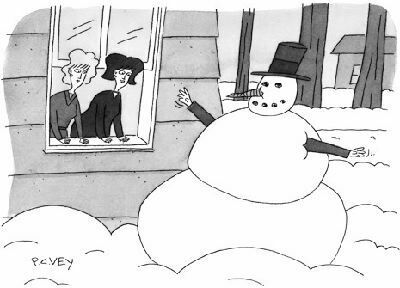

In [5]:
ds["train"][0]["image"]

In [6]:
ds["train"][0]["image_description"]

'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.'

We don't have to write any function to embed examples or create an index. 🤗 datasets library's FAISS integration abstracts these processes. We can simply use `map` method of the dataset to create a new column with the embeddings for each example like below. Let's create one for text features on the prompt column.

In [7]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(lambda example: {'embeddings': model.get_text_features(**tokenizer([example["image_description"]], truncation=True, return_tensors="pt").to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [12]:
ds_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

We can do the same and get the image embeddings.

In [9]:
ds_with_embeddings = ds_with_embeddings.map(lambda example: {'image_embeddings': model.get_image_features(**processor([example["image"]], return_tensors="pt").to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [10]:
ds_with_embeddings.add_faiss_index(column='image_embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

## Text Query

We can now query the dataset with text or image to get similar items from it.

In [17]:
prmt = "a snowy day"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', prmt_embedding, k=1)

['A man is in the snow. A boy with a huge snow shovel is there too. They are outside a house.']


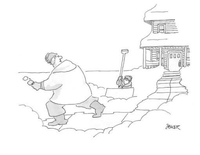

In [19]:
def downscale_images(image):
  width = 200
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  return img

images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])



## Image Similarity Inference

Image similarity inference is similar, where you just call `get_image_features`.

In [22]:
import requests
# image of a beaver
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
image = Image.open(requests.get(url, stream=True).raw)


Search for the similar image.

In [25]:
img_embedding = model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('image_embeddings', img_embedding, k=1)

Display the most similar image to the retro woman artwork.

['Salmon swim upstream but they see a grizzly bear and are in shock. The bear has a smug look on his face when he sees the salmon.']


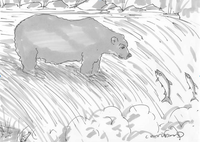

In [26]:
images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])

## Saving and loading the embeddings
We can save the dataset with embeddings with `save_faiss_index`.


In [27]:
ds_with_embeddings.save_faiss_index('embeddings', 'my_index.faiss')

  We can load the embeddings to the dataset with no embeddings using `load_faiss_index`.

In [37]:
ds = ds["train"]
ds.load_faiss_index('embeddings', 'my_index.faiss')
# infer again
prmt = "people under the rain"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds.get_nearest_examples('embeddings', prmt_embedding, k=1)

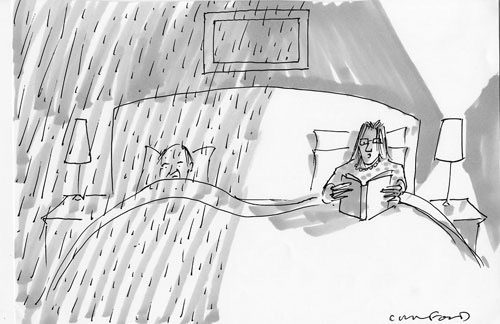

In [39]:
display(retrieved_examples["image"][0])